<a href="https://colab.research.google.com/github/apester/PINN/blob/main/ODE_PINN_MLP_KAN_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: Solving an ODE with Physics-Informed Neural Networks (PINNs)

## MLP vs KAN-style Network

**ODE:**

\[
 y'(x) = -y(x) + e^{-x},\quad y(0)=1,\quad x\in[0,1].
\]

### Learning objectives

By the end of this lab you should be able to:

1. Derive the analytic solution of a first-order linear ODE.

2. Formulate a physics-informed neural network (PINN) for a given ODE.

3. Implement a PINN using:

   - a standard MLP (two hidden layers, sigmoid),

   - a simple KAN-style architecture with polynomial basis functions.

4. Train both networks, visualize their solutions, and compare their errors.

5. Reflect on advantages and limitations of MLP vs KAN-style architectures for PINNs.


## 1. Analytic solution of the ODE

We start from

\[
 y'(x) = -y(x) + e^{-x}.
\]

Rewrite in standard form:

\[
 y' + y = e^{-x}.
\]

This is a linear ODE. The integrating factor is

\[
 \mu(x) = e^{\int 1\,dx} = e^x.
\]

Multiply the equation by \(e^x\):

\[
 e^x y' + e^x y = 1 \Rightarrow \frac{d}{dx}(e^x y) = 1.
\]

Integrate:

\[
 e^x y = x + C \Rightarrow y(x) = e^{-x}(x + C).
\]

Use the initial condition \(y(0)=1\):

\[
 y(0) = 1 = e^0(0 + C) = C.
\]

So the exact solution is

\[
 y_{\text{exact}}(x) = e^{-x}(x+1).
\]

We will use this only for validation, not for training.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
device = torch.device('cpu')  # set to 'cuda' if you have a GPU
torch.manual_seed(0)
np.random.seed(0)

# Exact solution helper

def y_exact(x: torch.Tensor) -> torch.Tensor:
    # Exact solution y(x) = e^{-x}(x + 1)
    return torch.exp(-x) * (x + 1.0)


## 2. Physics-Informed Neural Network (PINN) formulation

We look for a neural network–based function \(y(x)\) that satisfies

\[
 y'(x) = -y(x) + e^{-x}, \quad y(0)=1.
\]

Instead of training a network directly on data, we train it to minimize the residual of the ODE.


### 2.1 Trial solution

Let \(N(x;\theta)\) be a neural network with scalar output. We build a trial solution that automatically satisfies the initial condition:

\[
 y_{\text{trial}}(x) = 1 + x\,N(x;\theta).
\]

At \(x = 0\): \(y_{\text{trial}}(0) = 1\) for any \(\theta\). So we only need to enforce the differential equation on \((0,1].\)


### 2.2 Residual and loss

The ODE can be written as

\[
 y' + y - e^{-x} = 0.
\]

With our trial solution,

\[
 R(x) = \frac{d}{dx}y_{\text{trial}}(x) + y_{\text{trial}}(x) - e^{-x}
\]

is the residual. If \(y_{\text{trial}}\) is exact, \(R(x) = 0\).


We define the PINN loss over collocation points \(x_i \in [0,1]\):

\[
 \mathcal{L}(\theta) = \frac{1}{N}\sum_{i=1}^N R(x_i)^2.
\]


In [2]:
def make_trial(model):
    """Construct trial solution y_trial(x) = 1 + x * N(x)."""
    def y_trial(x):
        return 1.0 + x * model(x)
    return y_trial


def make_dy_dx(y_trial):
    """Return function computing dy/dx via autograd."""
    def dy_dx(x):
        y = y_trial(x)
        dy = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]
        return dy
    return dy_dx


def make_residual_loss(y_trial):
    """Residual loss for y' = -y + e^{-x} (i.e., y' + y - e^{-x} = 0)."""
    dy = make_dy_dx(y_trial)

    def residual_loss(x):
        x.requires_grad_(True)
        d_y = dy(x)
        y_val = y_trial(x)
        rhs = torch.exp(-x)
        residual = d_y + y_val - rhs
        return torch.mean(residual**2)

    return residual_loss


## 3. PINN with an MLP (two hidden layers, sigmoid)

We now define an MLP:

- Input: \(x \in \mathbb{R}\)
- Hidden layer 1: 20 neurons, sigmoid
- Hidden layer 2: 20 neurons, sigmoid
- Output: 1 neuron (scalar), linear

This network will be our \(N(x;\theta)\) in the trial solution.


In [3]:
class MLP(nn.Module):
    def __init__(self, n_hidden=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Sigmoid(),
            nn.Linear(n_hidden, n_hidden),
            nn.Sigmoid(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.net(x)


mlp = MLP(n_hidden=20).to(device)
y_trial_mlp = make_trial(mlp)
residual_loss_mlp = make_residual_loss(y_trial_mlp)


### 3.1 Training the MLP-based PINN

We use random collocation points \(x_i \sim U(0,1)\) in each epoch and minimize the residual loss with Adam.


In [4]:
n_epochs_mlp = 4000
n_collocation = 100
learning_rate = 1e-3

optimizer_mlp = optim.Adam(mlp.parameters(), lr=learning_rate)
loss_history_mlp = []

for epoch in range(1, n_epochs_mlp + 1):
    x_col = torch.rand((n_collocation, 1), device=device)
    optimizer_mlp.zero_grad()
    loss = residual_loss_mlp(x_col)
    loss.backward()
    optimizer_mlp.step()
    loss_history_mlp.append(loss.item())
    if epoch % 500 == 0:
        print(f"[MLP] Epoch {epoch:5d}/{n_epochs_mlp}, Loss = {loss.item():.3e}")


[MLP] Epoch   500/4000, Loss = 9.201e-04
[MLP] Epoch  1000/4000, Loss = 6.762e-04
[MLP] Epoch  1500/4000, Loss = 4.049e-04
[MLP] Epoch  2000/4000, Loss = 1.236e-04
[MLP] Epoch  2500/4000, Loss = 1.517e-05
[MLP] Epoch  3000/4000, Loss = 3.250e-06
[MLP] Epoch  3500/4000, Loss = 2.674e-06
[MLP] Epoch  4000/4000, Loss = 2.712e-06


### 3.2 Evaluation of MLP PINN
We evaluate the trained model on a fine grid and compare with the exact solution.


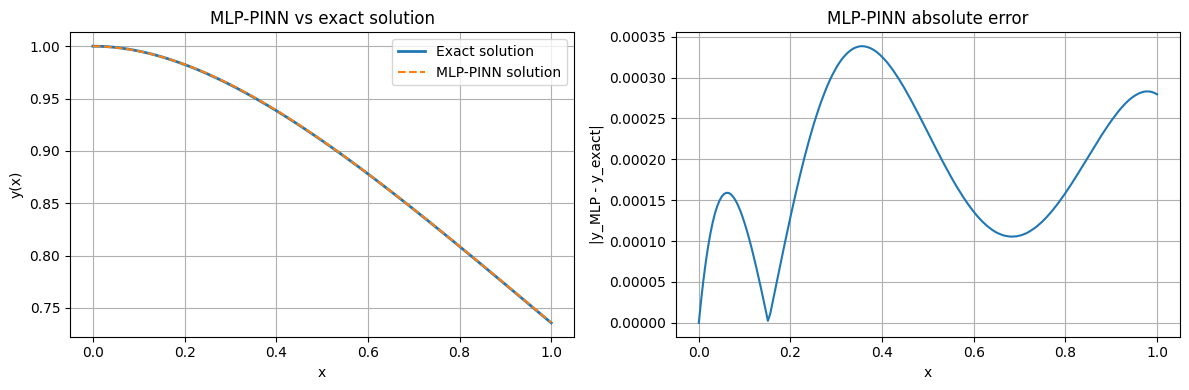

In [5]:
x_test = torch.linspace(0, 1, 200).view(-1, 1).to(device)

with torch.no_grad():
    y_mlp = y_trial_mlp(x_test)
    y_ref = y_exact(x_test)

x_np = x_test.cpu().numpy().flatten()
y_mlp_np = y_mlp.cpu().numpy().flatten()
y_ref_np = y_ref.cpu().numpy().flatten()
err_mlp = np.abs(y_mlp_np - y_ref_np)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(x_np, y_ref_np, label='Exact solution', linewidth=2)
plt.plot(x_np, y_mlp_np, '--', label='MLP-PINN solution')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('MLP-PINN vs exact solution')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x_np, err_mlp)
plt.xlabel('x')
plt.ylabel('|y_MLP - y_exact|')
plt.title('MLP-PINN absolute error')
plt.grid(True)

plt.tight_layout()
plt.show()


### 3.3 Questions

1. Where is the error largest: near \(x=0\) or near \(x=1\)? Why might that happen?

2. Reduce `n_epochs_mlp` to 1000. How does the solution quality change?

3. Change the activation function in `MLP` from `Sigmoid` to `Tanh` or `ReLU` and compare.

4. Modify the trial solution to enforce \(y(1)=0\) instead of \(y(0)=1\).


## 4. PINN with a simple KAN-style network

Kolmogorov–Arnold Networks (KANs) replace standard linear+activation layers by learnable 1D functions.

Here we approximate this idea with a polynomial basis:

- For input vector \(x\), form \([x, x^2, ..., x^d]\).
- A linear layer then mixes these basis functions.

This is not a full modern KAN, but it illustrates the concept.


In [6]:
class KANLayer1D(nn.Module):
    # Simple KAN-style layer using polynomial basis
    def __init__(self, in_dim, out_dim, degree=4):
        super().__init__()
        self.in_dim = in_dim
        self.degree = degree
        self.linear = nn.Linear(in_dim * degree, out_dim)

    def forward(self, x):
        powers = [x**k for k in range(1, self.degree + 1)]
        feats = torch.cat(powers, dim=1)
        return self.linear(feats)


class SimpleKAN(nn.Module):
    # Small KAN-style network with two KAN layers
    def __init__(self, hidden_dim=16, degree=4):
        super().__init__()
        self.layer1 = KANLayer1D(1, hidden_dim, degree)
        self.layer2 = KANLayer1D(hidden_dim, hidden_dim, degree)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h1 = self.layer1(x)
        h2 = self.layer2(h1)
        return self.out(h2)


kan = SimpleKAN(hidden_dim=16, degree=4).to(device)
y_trial_kan = make_trial(kan)
residual_loss_kan = make_residual_loss(y_trial_kan)


### 4.1 Training the KAN-style PINN
We use the same strategy and hyperparameters as for the MLP.


In [7]:
n_epochs_kan = 4000
optimizer_kan = optim.Adam(kan.parameters(), lr=learning_rate)
loss_history_kan = []

for epoch in range(1, n_epochs_kan + 1):
    x_col = torch.rand((n_collocation, 1), device=device)
    optimizer_kan.zero_grad()
    loss = residual_loss_kan(x_col)
    loss.backward()
    optimizer_kan.step()
    loss_history_kan.append(loss.item())
    if epoch % 500 == 0:
        print(f"[KAN] Epoch {epoch:5d}/{n_epochs_kan}, Loss = {loss.item():.3e}")


[KAN] Epoch   500/4000, Loss = 2.743e-04
[KAN] Epoch  1000/4000, Loss = 1.161e-04
[KAN] Epoch  1500/4000, Loss = 4.679e-05
[KAN] Epoch  2000/4000, Loss = 3.118e-05
[KAN] Epoch  2500/4000, Loss = 2.445e-05
[KAN] Epoch  3000/4000, Loss = 6.047e-06
[KAN] Epoch  3500/4000, Loss = 1.418e-05
[KAN] Epoch  4000/4000, Loss = 5.276e-06


### 4.2 Comparing MLP-PINN and KAN-style PINN
We evaluate the KAN-style network on the same grid and compare solutions and errors.


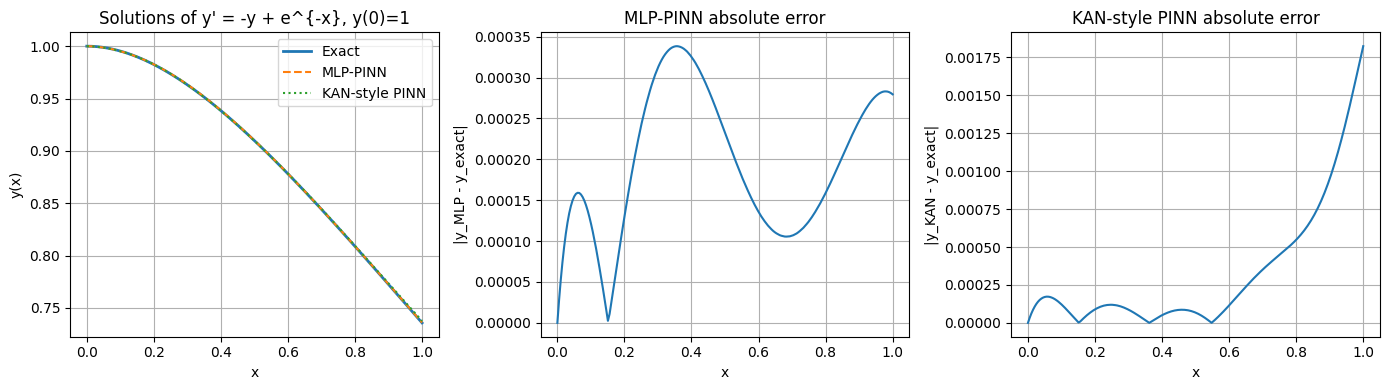

In [8]:
with torch.no_grad():
    y_kan = y_trial_kan(x_test)

y_kan_np = y_kan.cpu().numpy().flatten()
err_kan = np.abs(y_kan_np - y_ref_np)

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.plot(x_np, y_ref_np, label='Exact', linewidth=2)
plt.plot(x_np, y_mlp_np, '--', label='MLP-PINN')
plt.plot(x_np, y_kan_np, ':', label='KAN-style PINN')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title("Solutions of y' = -y + e^{-x}, y(0)=1")
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(x_np, err_mlp)
plt.xlabel('x')
plt.ylabel('|y_MLP - y_exact|')
plt.title('MLP-PINN absolute error')
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(x_np, err_kan)
plt.xlabel('x')
plt.ylabel('|y_KAN - y_exact|')
plt.title('KAN-style PINN absolute error')
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. Discussion & Extensions

1. Compare the maximum absolute error of the MLP-PINN and the KAN-style PINN.

2. Plot `loss_history_mlp` and `loss_history_kan` versus epoch and compare convergence.

3. Change the polynomial degree in `KANLayer1D` (e.g. 2 or 6). How does this affect accuracy?

4. Try another ODE, e.g. \(y' = -y^2 + \sin x, \ y(0)=0\), and adapt the residual.
